In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
l = pd.read_csv('l_494by4.csv', sep=',',header=None).values
h = pd.read_csv('h_116by4.csv', sep=',',header=None).values
print(l.shape, h.shape)

#### read the diagnosis from CDR, turn into dict
diag = pd.read_csv("ADNI1_patient_diagnosis.csv").set_index('RID')
diag = diag.astype(float)
## head count for each category
# print(diag['m48'].value_counts())

labels = {}
for i in diag.index.values:
    if diag.loc[i,'m48'] == 0:
        labels[i] = "Normal"
    elif diag.loc[i,'m48'] == 0.5:
        labels[i] = "Questionable"
    elif diag.loc[i,'m48'] == 1:
        labels[i] = "Mild"
    elif diag.loc[i,'m48'] == 2:
        labels[i] = "Moderate"
    elif diag.loc[i,'m48'] == 3:
        labels[i] = "Severe"
    else:
        labels[i] = 'Not determined'
#print(labels)

normal_group = []
AD_group = []
combined_group = []

corr_mats = os.listdir('Longitudinal_FreeSurfer_adjmat')
for i in corr_mats:
#     df = pd.read_csv('CrossSectional_FreeSurfer_adjmat/' + i, index_col=0)
    df = pd.read_csv('Longitudinal_FreeSurfer_adjmat/' + i, index_col=0)
    pat = int(i.split('.')[0].split('_')[1])
        
    if df.shape[0] == 116:
        if labels[pat] == 'Normal' or labels[pat] == 'Questionable':
            normal_group = np.append(normal_group, pat)
            combined_group = np.append(combined_group, pat)
        elif labels[pat] == 'Mild' or labels[pat] == 'Moderate' or labels[pat] == 'Severe':
            AD_group = np.append(AD_group, pat)
            combined_group = np.append(combined_group, pat)

print(np.size(combined_group))
print(np.size(normal_group))
print(np.size(AD_group))

(494, 4) (116, 4)
494
322
172


In [3]:
### part 1
'''
For patient i, sigmoid(LiHH^t) = matrix of size 116*116, element ij = P(edge between structure i and j). 
Under model, every edge is sample independently as Bernoulli RV with this probability. 
Pick 2 patients, 1 healthy and 1 disease, construct their matrix and 
sample from the matrix to construct some sample graphs.
'''
import math

def sigmoid(x):
    if x < 0:
        return 1 - 1/(1 + math.exp(x))
    else:
        return 1/(1 + math.exp(-x))
    
def sim_adj_mat(prob_matrix):
    adj_mat = np.zeros((116, 116))
    for i in range(116):
        for j in range(i+1, 116):
            prob = sigmoid(prob_matrix[i,j]) ## make it a probability
            adj_mat[i,j] = np.random.binomial(1, p=prob)
    print(np.sum(adj_mat))
    return adj_mat

In [4]:
def sim_both_groups(l_mat, n, dim):
    normal_pat = np.random.choice(normal_group,n)
    AD_pat = np.random.choice(AD_group,n)
    normal_sim_data = np.zeros((n,116,116))
    AD_sim_data = np.zeros((n,116,116))

    for i in range(n):
        healthy_idx = np.where(combined_group == normal_pat[i])[0]
        AD_idx = np.where(combined_group == AD_pat[i])[0]

        healthy_mat = l_mat[healthy_idx,dim] * np.matmul(h, np.transpose(h)) ##element ij is the prob of edge between
        AD_mat = l_mat[AD_idx,dim] * np.matmul(h, np.transpose(h))

        ### simulate patient data
        normal_sim_data[i,:,:] = sim_adj_mat(healthy_mat)
        AD_sim_data[i,:,:] = sim_adj_mat(AD_mat)
    return normal_sim_data, AD_sim_data

In [5]:
fixed_l_normal, fixed_l_AD = sim_both_groups(l,5,0)

2398.0
644.0
362.0
476.0
2224.0
247.0
209.0
860.0
167.0
909.0


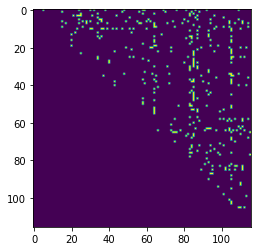

In [7]:
import matplotlib.pyplot as plt

f, ax = plt.subplots()
ax.imshow(fixed_l_normal[1])

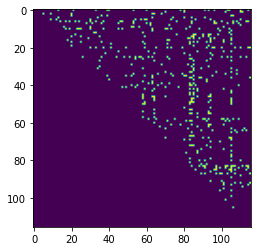

In [10]:
f2, ax2 = plt.subplots()
ax2.imshow(fixed_l_AD[1])

In [89]:
### part 2
'''
Instead of picking 2 patients, we will model L as RV also, want to model as multi-variate Gaussian()
once for healthy and once for the disease. 
Generate a few random samples from this model. Use different mean and common covariance. 
L = patients*4, find the mean of each group, subtract group mean from each sample in group in L, 
covariance matrix = 4*4(L^tL/#patients). 
Then to sample from Multivariate Gaussian, sample 4 from independent standard normal variables, 
left multiple by sqrt(covariance)(scipy.linalg.sqrtm), add the mean.
'''
real_mean_normal = np.zeros((1,4))
real_mean_AD = np.zeros((1,4))
for i in range(len(combined_group)):
    pat = combined_group[i]
    if pat in normal_group:
        real_mean_normal += l[i,:]
    elif pat in AD_group:
        real_mean_AD += l[i,:]
real_mean_normal = real_mean_normal/len(normal_group)
real_mean_AD = real_mean_AD/len(AD_group)
# print(np.mean(l, axis=0))
print(real_mean_normal)
print(real_mean_AD)

[[-177.55846259    7.33423375   10.41214594  -12.08141209]]
[[ 702.17742087 -205.67251417 -118.71060243   98.76311192]]


In [97]:
import scipy

## get covariance matrix and updated mean vectors from distance
### if distance = 0, then same as real data
def get_params(real_mean_normal, real_mean_AD, distance):
    mean_normal = np.zeros((1,4))
    mean_AD = np.zeros((1,4))
    mean_normal += distance * (real_mean_normal + real_mean_AD) / 2
    mean_AD = real_mean_AD
    
    l_mean_subtracted = l
    ## subtract group mean from each group in l
    for i in range(len(combined_group)):
        pat = combined_group[i]
        if pat in normal_group:
            l_mean_subtracted[i,:] = l_mean_subtracted[i,:] - mean_normal
        elif pat in AD_group:
            l_mean_subtracted[i,:] = l_mean_subtracted[i,:] - mean_AD

    covar_mat = np.matmul(np.transpose(l_mean_subtracted),l_mean_subtracted)/np.size(combined_group)
    return mean_normal, mean_AD, covar_mat

def sim_both_groups_l_var(real_mean_normal, real_mean_AD, distance, n, dim):
    sim_mean_normal, sim_mean_AD, sim_covar = get_params(real_mean_normal, real_mean_AD, distance)

    sim_l = np.zeros((len(combined_group),4))
    for i in range(494):
        sim_l[i,:] = np.random.normal(0,1,4) ##how is this different from sampling from np.random.multivariate_normal?
                
    sim_l = np.matmul(sim_l, scipy.linalg.sqrtm(sim_covar)) ## left mult by square root of covar matrix

    for i in range(len(combined_group)): ## add mean back in
        pat = combined_group[i]
        if pat in normal_group:
            for k in range(4):
                sim_l[i,k] += sim_mean_normal[0,k]
        elif pat in AD_group:
            for k in range(4):
                sim_l[i,k] += sim_mean_AD[0,k]
#     print(sim_l.shape)

    var_l_normal, var_l_AD = sim_both_groups(sim_l,n,dim)
    return var_l_normal, var_l_AD

In [98]:
### normal distance
n=2
dim=0

var_l_normal_d0, var_l_AD_d0 = sim_both_groups_l_var(real_mean_normal, real_mean_AD, 0, n, dim)

print('decrease distance between group mean')
var_l_normal_close, var_l_AD_close = sim_both_groups_l_var(real_mean_normal, real_mean_AD, 0.5, n, dim)

print('increase distance between group mean')
var_l_normal_far, var_l_AD_far = sim_both_groups_l_var(real_mean_normal, real_mean_AD, -0.5, n, dim)

31.0
6639.0
6639.0
6639.0
decrease distance between group mean
6639.0
31.0
6639.0
31.0
increase distance between group mean
6639.0
6639.0
31.0
6639.0
